# HW3: The Centralized Curator Model

### Bhaven Patel
### 4/2/2019

I worked with Anthony Rentsch, Lipika Ramaswamy, and Karina Huang on this homework.

My code can be found on my [Github](https://github.com/bhavenp/cs208/blob/master/homework/HW3/HW3_Bhaven_Patel.ipynb).

## Problem 1: Tails, Trimming, and Winsorization


**(a)**<br>

$$
M(x)=\dfrac{1}{0.9n}\left(\sum_{P_0.05 \leq x_i \leq P_0.95} x_i\right) + Lap\left( \dfrac{D}{0.9n\epsilon} \right)
$$

This implementation of the Trimmed mean is $\epsilon$-DP if the trimming transformation $T$ on $x$ ($x$ is trimmed from its 5th to its 95th percentile) is c-Lipschitz with $c=1$ and the mechanism $M$ is $\epsilon$-DP.

First, we can show that the trimming transformation $T$ on $x$ is c-Lipschitz with $c=1$:<br>
Begin with $x$ and $x'$, which hold $n$=20 values each in the range [0,...,D]
$$
x = [x_1, ..., x_{20}]\\
x' = [x_2, ..., x_{21}]\\
$$

The trimming transformation $T$ applied to $x$ and $x'$ would result in
$$
T(x) = [x_2, ..., x_{19}]\\
T(x') = [x_3, ..., x_{20}]\\
$$

$T(x)$ is $c$-Lipschitz if $\forall x,x' \;\; d(T(x), T(x')) \leq c\cdot d(x, x')$, where $d(x, x')$ denotes the distance between datasets $x$ and $x'$ defined by the number of rows you would need to change in $x'$ to make it the same as $x$. In this case, $d(x, x') = 1$ and $d(T(x), T(x')) = 1$, so $c=1$. Thus, $T(x)$ is $c$-Lipschitz with $c=1$. This would hold for any value of $n$.

A mechanism $M$ is $\epsilon$-DP when adding Laplace noise sampled from $Lap\left(\dfrac{GS}{\epsilon}\right)$, where $GS$ is the global sensitivity. In our case, the $GS = \dfrac{D}{0.9n}$ and we are adding $Lap\left(\dfrac{D}{0.9n\epsilon}\right)$ noise, so our mechanism is $\epsilon$-DP. From the lemma in class, since $M$ is $\epsilon$-DP and $T$ is $1$-Lipschitz, then $M\circ T$ is $1 \cdot \epsilon$-DP. Thus, this Trimmed mean algorithm is $\epsilon$-DP.


The code for the implementation is below.

In [82]:
rm(list=ls())		# Remove any objects in memory

#### Parameters ####

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))


sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}

In [83]:
# Generate a dataset of size
#
# max_value- maximum value any element in the dataset should take on
# size- number of elements to include in dataset
# 
# returns a differentially private mean release from the trimmed data

create_dataset = function(max_value, size){
    return(sample(0:max_value, size = size, replace = TRUE));
}

In [3]:
# Trimmed mean function for releasing a DP mean from data trimmed to its 5% to 95% intervals
#
# x- numeric vector of values
# max_value- maximum value any element in 'x' may take
# epsilon- privacy loss parameter
# 
# returns a differentially private mean release from the trimmed data

trimmed_mean = function(x, max_value, epsilon){
    n <- length(x); #get number of elements in x
    #get 5% and 95% cutoff values
    cutoffs <- quantile(x, probs = c(0.05, 0.95) )
    lower = cutoffs[1];
    upper = cutoffs[2];
    x.trimmed <- x[x >= lower & x <= upper]; #trim x
    
    sensitivity <- max_value/ (0.9*n);
    scale <- sensitivity / epsilon; #scale for Laplace noise

    sensitiveValue <- mean(x.trimmed)
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)

    return(list(release=DPrelease, true=sensitiveValue));
}

In [4]:
max_value = 10;
size = 20;

test <- create_dataset(max_value, size);
print(test)

trimmed_mean(test, max_value = max_value, epsilon = 0.4)

 [1]  1  7  3  7  9  5  9  5  7  9  3  4  4  1  2  4  8  6 10  8


$release
[1] 6.440918

$true
[1] 5.368421

<hr>

**(b)**<br>

<hr>

**(c)**<br>

## Need to describe implementation of percentile release

In [112]:
# percentile mean function for releasing a DP percentile from data 
#
# x- numeric vector of values
# tperc- percentile for which value from x should be chosen (0,100)
# epsilon- privacy loss parameter
# 
# returns a differentially private percentile release from the data
percentileRelease <- function(x, tperc, epsilon){
	n <- length(x); #get number of values in x
	bins <- sort(x, decreasing = FALSE); #making a new copy of x to keep downstream variable names the same
    sensitiveValue <- quantile(bins, probs = c(tperc)); #get the true value at the desired percentile 
    
    sensitivity = 1; #sensitivity for our utility function is 1
	likelihoods <- rep(NA, n); #create vector to hold the likelihood for each bin

	for(i in 1:length(likelihoods)){ #calculate the utility of each bin
        #the number of values in 'x' below and equal to the current value is 'i'
        util = n - abs(n*tperc - i); #get difference between the true percentile and fraction of
        distToNextValue = 1;
        if(i != length(likelihoods) ){
            distToNextValue = bins[i+1] - bins[i] + 1; 
        }
        #the likelihood needs to get scaled 
        likelihoods[i] <- distToNextValue * exp(epsilon * util / 2 * sensitivity);
	}
    
    #calculate the actual probabilities for each bin
	probabilities <- likelihoods/sum(likelihoods);
    
    flag <- runif(n=1, min=0, max=1) < cumsum(probabilities) # See also rmultinom()
    bInd <- which(flag == 1)[1]; #get the index of the first bin with probability
    
    #determine if this bin covers a range of values
    DPrelease <- bins[bInd]; #get initial value for DPrelease of percentile
    if(bInd + 1 < n){ #check if there is a bin larger than chosen bin
        distToNextValue = bins[bInd+1] - bins[bInd]; #determine distance between
        if(distToNextValue > 1){
            DPrelease <- sample(from=bins[i], to=bins[i+1]-1);
        }
    }
#     DPrelease <- min(bins[flag]); 

    return(list(release=DPrelease, true=sensitiveValue))
}


In [113]:
# data <- create_dataset(max_value = 100, size = 100);
data <- seq(from = 1, to = 100)
print(data)

  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100


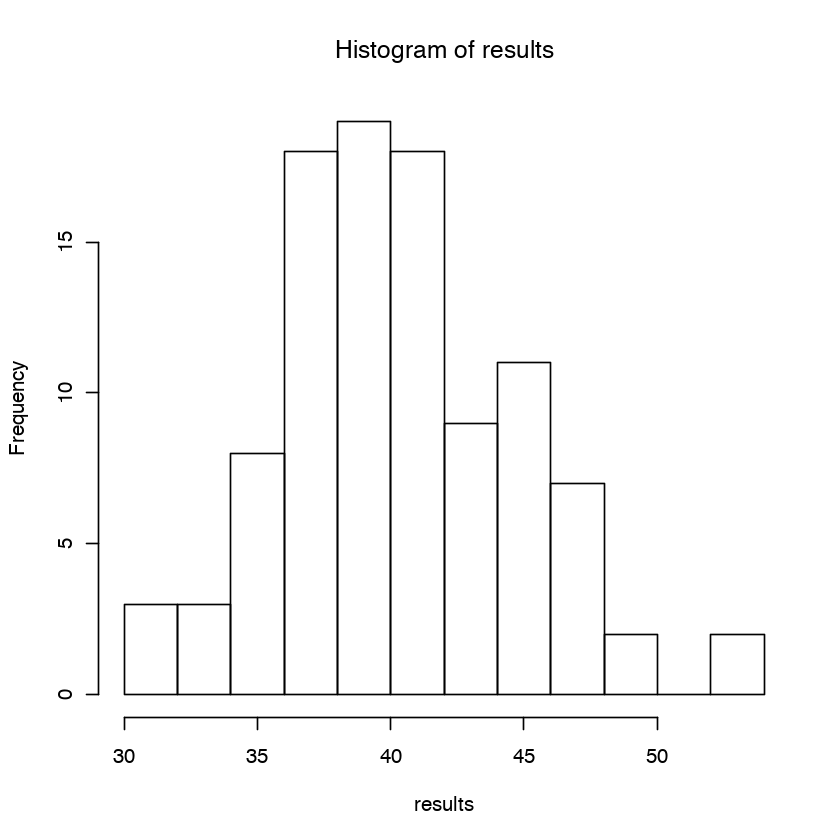

In [145]:
numSims = 100;
results <- c();
for(i in 1:100){
    r <- percentileRelease(data, tperc = 0.4, epsilon = 0.5)$release;
    results <- c(results, r);
}
hist(results)

<hr>

**(d)**<br>

<hr>

## Problem 2: Composition

In [25]:
library("PSIlence")
## PARAMETERS
delta = 10**(-9);
globalEps = 1;

kVals <- seq(from=1, to=100, by=1); #get sequence of values for k

results <- matrix( rep(NA,length(kVals)*3), nrow=length(kVals), ncol=4);

for(i in 1:length(kVals)){
    k = kVals[i];
    #calculate standard deviation for basic epsilon
    epsBasic = globalEps / k;
    stdBasic = sqrt(2) / epsBasic;
    #calculate standard deviation for basic epsilon
    epsAdv = globalEps / sqrt(2*k*log(1/delta));
    stdAdv = sqrt(2) / epsAdv;
    
    #calculate standard deviation for 
    init <- rep(c(0, 0), k )
    params <- matrix(init, nrow=k, ncol=2, byrow=TRUE)
    inverse <- PSIlence:::update_parameters(params=params, hold=0, eps=globalEps, del=delta)
    stdOpt = sqrt(2) / inverse[1,1];

    
    results[i, ] <- c(k, stdBasic, stdAdv, stdOpt);
}

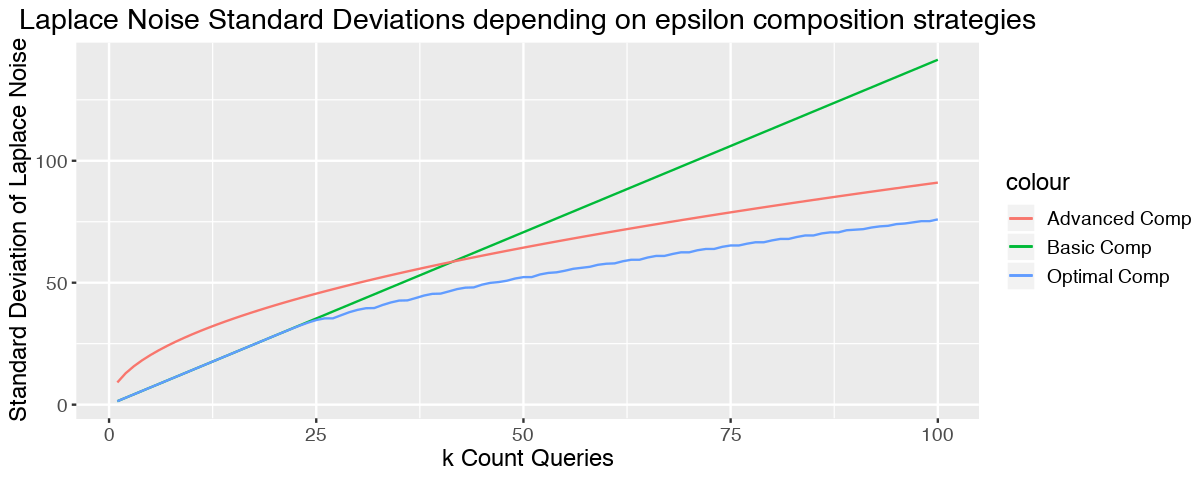

In [27]:
library(ggplot2)
library(grid)

final_results <- as.data.frame(results);
colnames(final_results) <- c("k", "Std_Basic_Comp", "Std_Adv_Comp", "Std_Opt_Comp");
f_size = 16;
fifty = 0.5;
# Plot the standard deviations 
p <- ggplot(data = final_results) + geom_line(aes(x=final_results$k, y=final_results$Std_Basic_Comp, color="Basic Comp")) + geom_line(aes(x=final_results$k, y=final_results$Std_Adv_Comp, color="Advanced Comp")) + geom_line(aes(x=final_results$k, y=final_results$Std_Opt_Comp, color="Optimal Comp")); 

p <- p + labs(title="Laplace Noise Standard Deviations depending on epsilon composition strategies", x="k Count Queries", y = "Standard Deviation of Laplace Noise") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size-2));

options(repr.plot.width=10, repr.plot.height=4); #set plot dimensions
p #show plot

In the graph above, we can see the expected trends:
1. For basic composition, the standard deviation of the Laplace noise added to each query answer increases linearly with the number of queries. This is because $\epsilon_0$ decrease proportional to $1/k$ so more noise is added with smaller $\epsilon_0$s. <br>
2. Advanced composition adds more noise to the queries for small $k$ than basic composition. However after $k=42$, advanced composition adds less noise than basic composition for higher values of $k$, so each answer has more utility.
<br>
3. Optimal composition does better than advanced composition for every value of $k$. Optimal composition does just as good as basic composition until $k=21$, after which it does much better than basic composition. It is obvious that optimal composition provides the best utility for any value of $k$.